<a href="https://colab.research.google.com/github/tarekujjaman/Data-Science/blob/main/bitcoin_price_prediction_arima_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Price Prediction Using ARIMA and Prophet

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import matplotlib
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


## Data Exploration

In [2]:
# Load data
df = pd.read_csv('BTC-USD-Daily-Price.csv')
df.head()

,Date,Close
0,2018-09-15,6543.200195
1,2018-09-16,6517.180176
2,2018-09-17,6281.200195
3,2018-09-18,6371.299805
4,2018-09-19,6398.540039


In [3]:
# Assuming 'date_column' is the name of your datetime column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


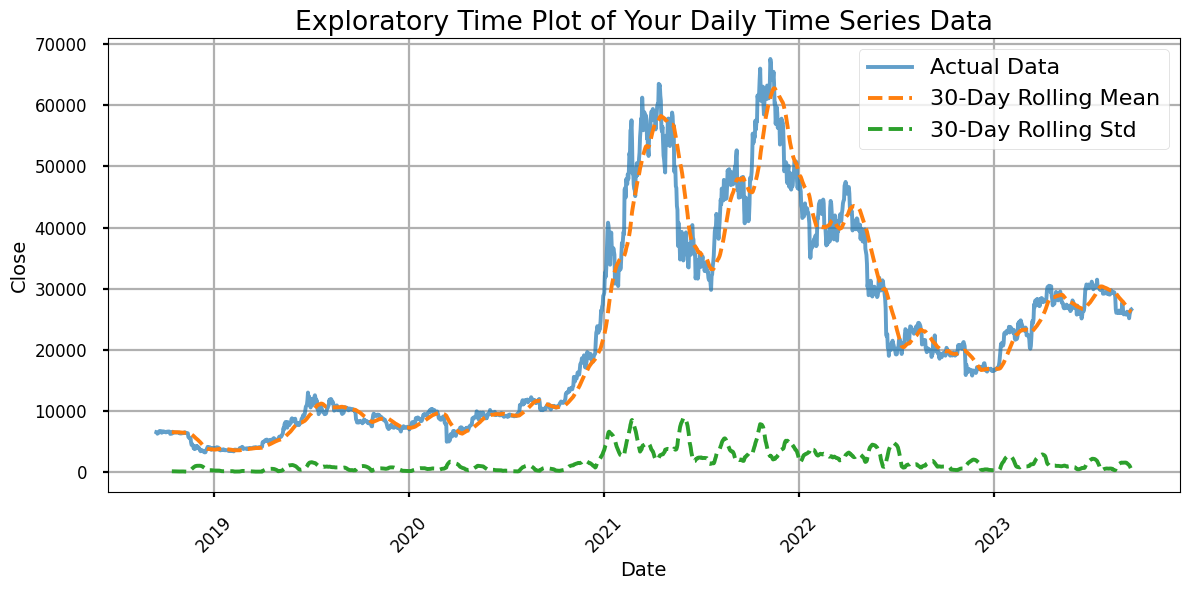

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Actual Data', linestyle='-', alpha=0.7)
rolling_mean = df['Close'].rolling(window=30).mean()
plt.plot(df.index, rolling_mean, label='30-Day Rolling Mean', linestyle='--')
rolling_std = df['Close'].rolling(window=30).std()
plt.plot(df.index, rolling_std, label='30-Day Rolling Std', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Exploratory Time Plot of Your Daily Time Series Data')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

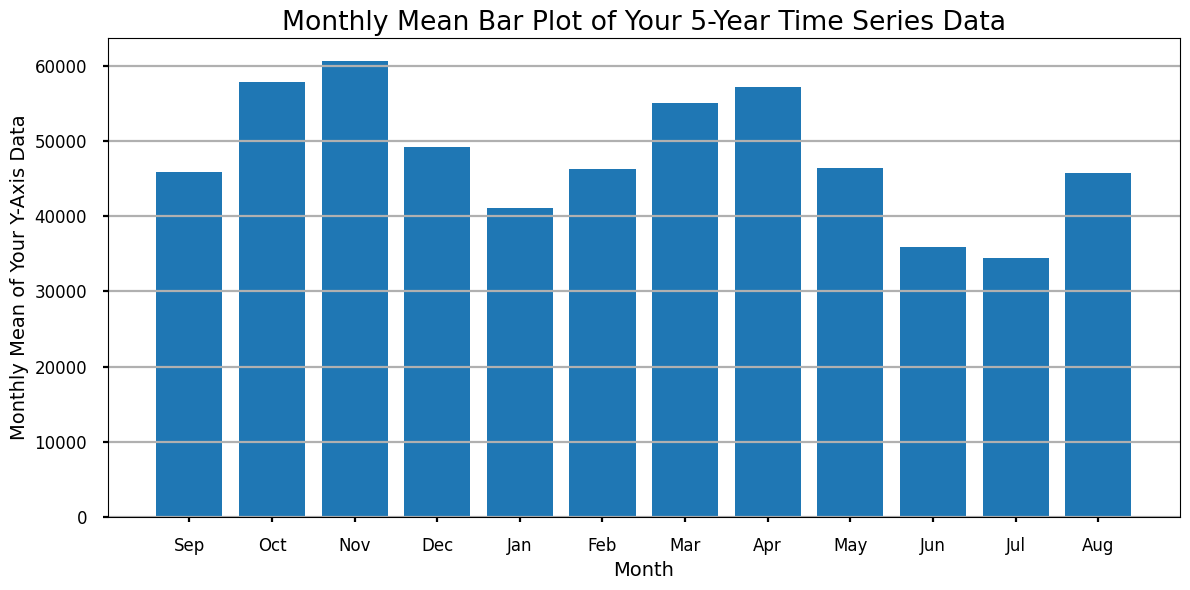

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
monthly_means = df['Close'].resample('M').mean()

# Extract month names from the index
monthly_means.index = monthly_means.index.strftime('%b')

# Create a bar plot of the 12-month means
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the monthly means as a bar plot
plt.bar(monthly_means.index, monthly_means)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Monthly Mean of Your Y-Axis Data')
plt.title('Monthly Mean Bar Plot of Your 5-Year Time Series Data')

# Show the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

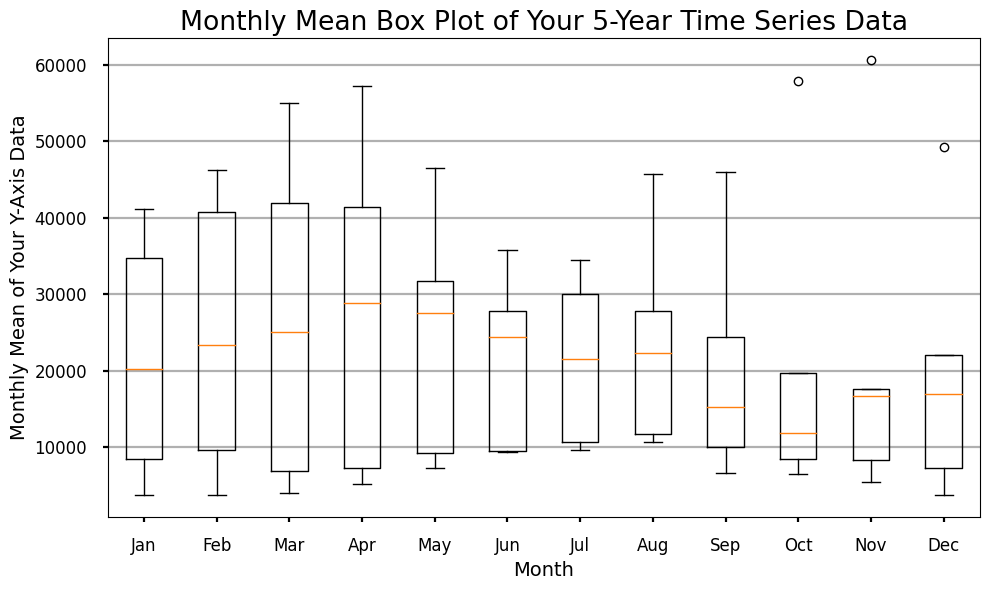

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the 12-month means
monthly_means = df['Close'].resample('M').mean()

# Extract month names from the index
monthly_means.index = monthly_means.index.strftime('%b')

# Create a box plot of the 12-month means
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the box plot
plt.boxplot([monthly_means['Jan'], monthly_means['Feb'], monthly_means['Mar'], monthly_means['Apr'],
             monthly_means['May'], monthly_means['Jun'], monthly_means['Jul'], monthly_means['Aug'],
             monthly_means['Sep'], monthly_means['Oct'], monthly_means['Nov'], monthly_means['Dec']],
            labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Monthly Mean of Your Y-Axis Data')
plt.title('Monthly Mean Box Plot of Your 5-Year Time Series Data')

# Show the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

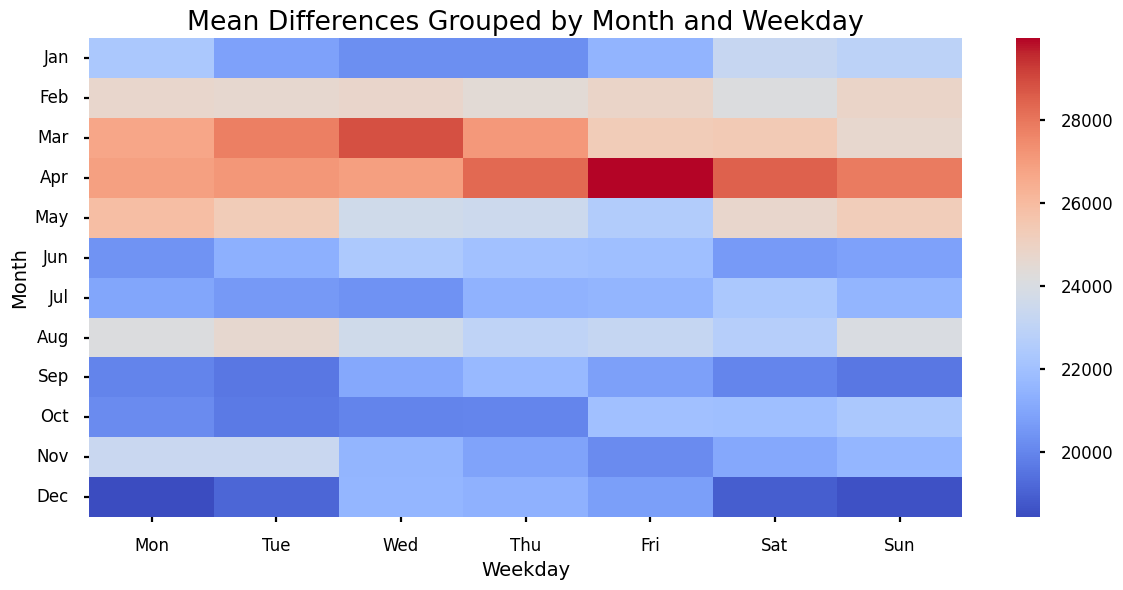

In [7]:
# Import necessary libraries
import seaborn as sns

# Calculate the mean differences grouped by month and weekday
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday
mean_diff_by_month_weekday = df.groupby(['Month', 'Weekday'])['Close'].mean().unstack()

# Define a list of month names for labeling
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
# Create a heatmap to visualize the mean differences
plt.figure(figsize=(12, 6))  # Set the figure size

# Use seaborn to create a heatmap
heatmap = sns.heatmap(mean_diff_by_month_weekday, cmap='coolwarm', xticklabels=weekday_names, yticklabels=month_names)

# Rotate the y-axis labels to be horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Add labels and title
plt.xlabel('Weekday')
plt.ylabel('Month')
plt.title('Mean Differences Grouped by Month and Weekday')

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
df['Close'].describe()

count     1827.000000
mean     22852.920776
std      16378.816669
min       3236.761719
25%       8935.923340
50%      19345.121090
75%      33734.515625
max      67566.828130
Name: Close, dtype: float64

Let's extract the average Closing Price of Bitcoin in each month

In [9]:
df_month = df.resample('MS').mean()
df_month.Close

Date
2018-09-01     6555.245666
2018-10-01     6485.118747
2018-11-01     5404.250171
2018-12-01     3717.488344
2019-01-01     3701.554963
                  ...     
2023-05-01    27499.307145
2023-06-01    27763.198438
2023-07-01    30057.469947
2023-08-01    27852.792844
2023-09-01    25948.744532
Freq: MS, Name: Close, Length: 61, dtype: float64

I will predict bitcoin prices by months.

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.415089


<Figure size 1500x700 with 0 Axes>

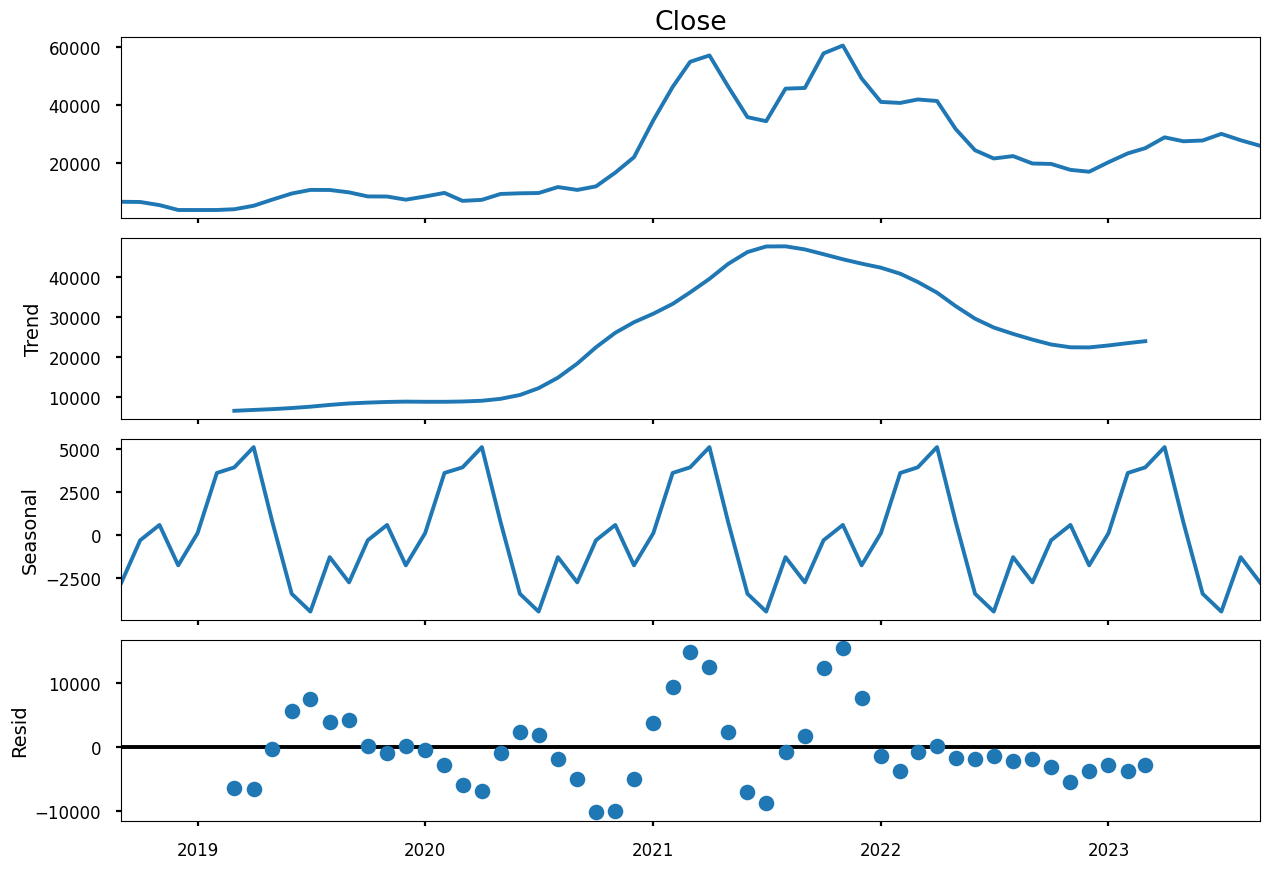

In [10]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [11]:
# Box-Cox Transformations
df_month['Close_box'], lmbda = stats.boxcox(df_month.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])

Dickey–Fuller test: p=0.415089


The series are not stationary.

## Seasonal differentiation

In [12]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Close_box - df_month.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.217940


The series are not stationary.

## Regular differentiation

Dickey–Fuller test: p=0.005861


<Figure size 1500x700 with 0 Axes>

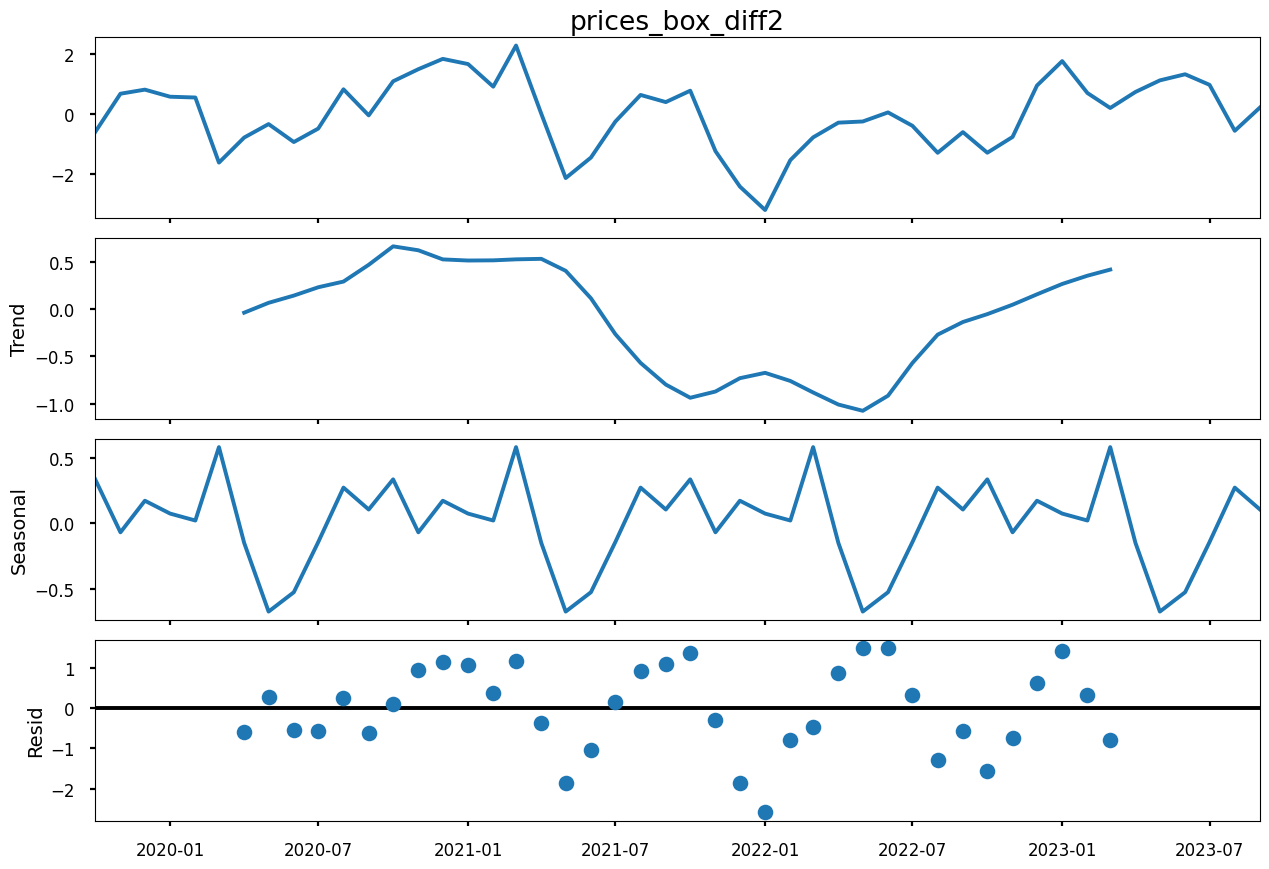

In [13]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

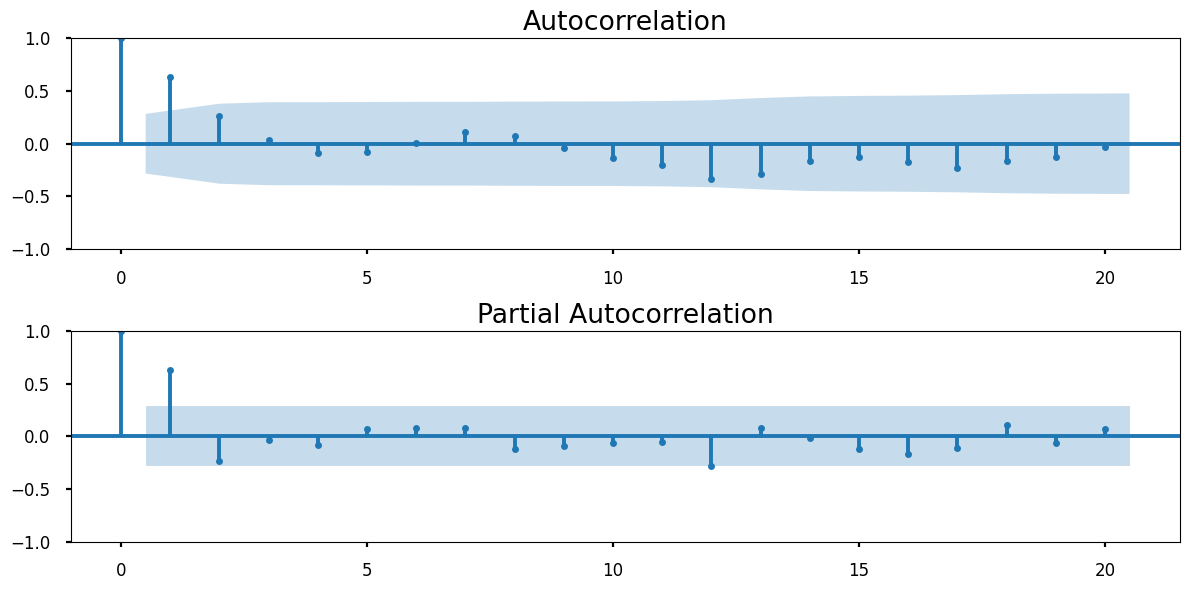

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(12,6))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)
plt.tight_layout()
plt.show()

In [15]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = [0, 3 ,12]
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Close_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (12, 0, 1, 0)
wrong parameters: (12, 0, 1, 1)
wrong parameters: (12, 0, 2, 0)
wrong parameters: (12, 0, 2, 1)
wrong parameters: (12, 1, 1, 0)
wrong parameters: (12, 1, 1, 1)
wrong parameters: (12, 1, 2, 0)
wrong parameters: (12, 1, 2, 1)
wrong parameters: (12, 2, 1, 0)
wrong parameters: (12, 2, 1, 1)
wrong parameters: (12, 2, 2, 0)
wrong parameters: (12, 2, 2, 1)


In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
13  (0, 2, 0, 1)  122.151123
17  (0, 2, 2, 1)  122.475000
15  (0, 2, 1, 1)  123.071770
7   (0, 1, 0, 1)  123.074378
23  (3, 0, 2, 1)  123.362278
                                      SARIMAX Results                                       
Dep. Variable:                            Close_box   No. Observations:                   61
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -57.076
Date:                              Wed, 20 Sep 2023   AIC                            122.151
Time:                                      19:39:41   BIC                            129.636
Sample:                                  09-01-2018   HQIC                           124.980
                                       - 09-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

## Analysis of residues

Dickey–Fuller test:: p=0.000000


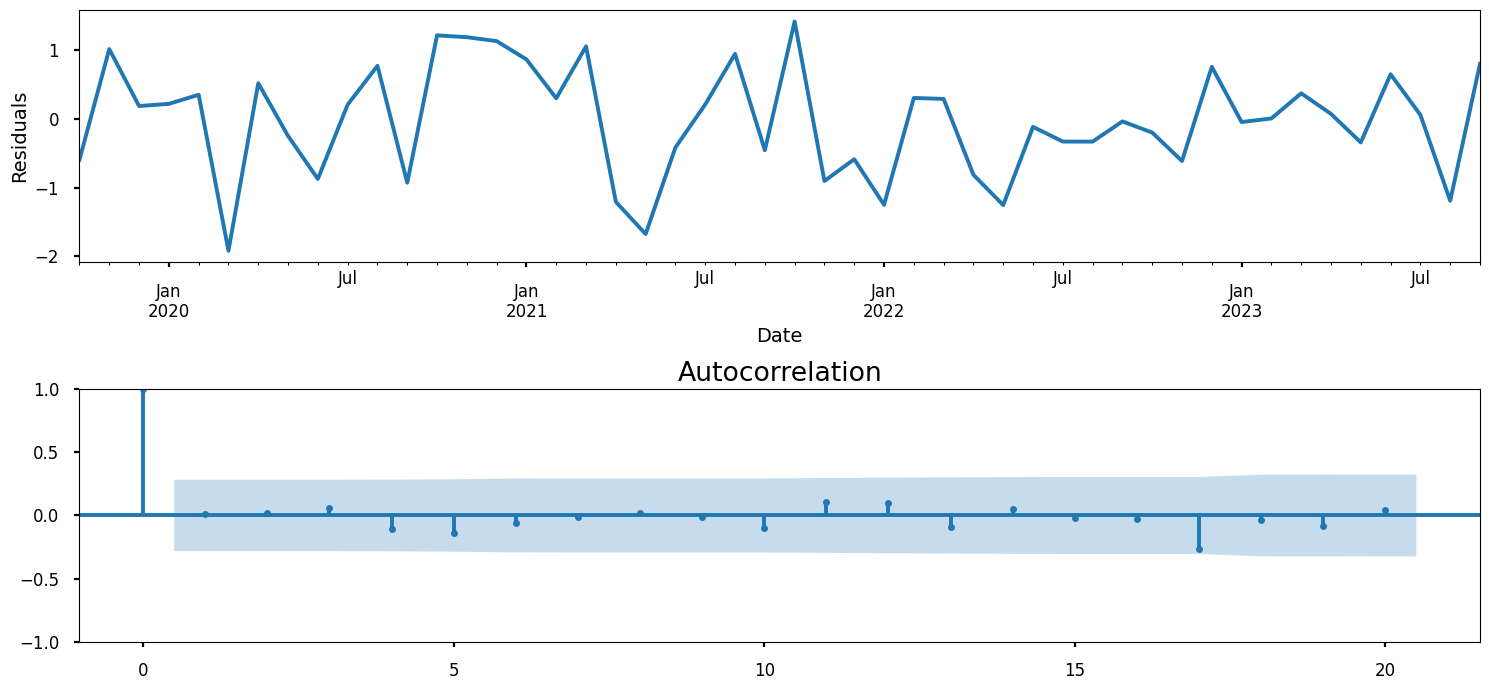

In [17]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=20, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

It`s OK.

## Prediction

In [18]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

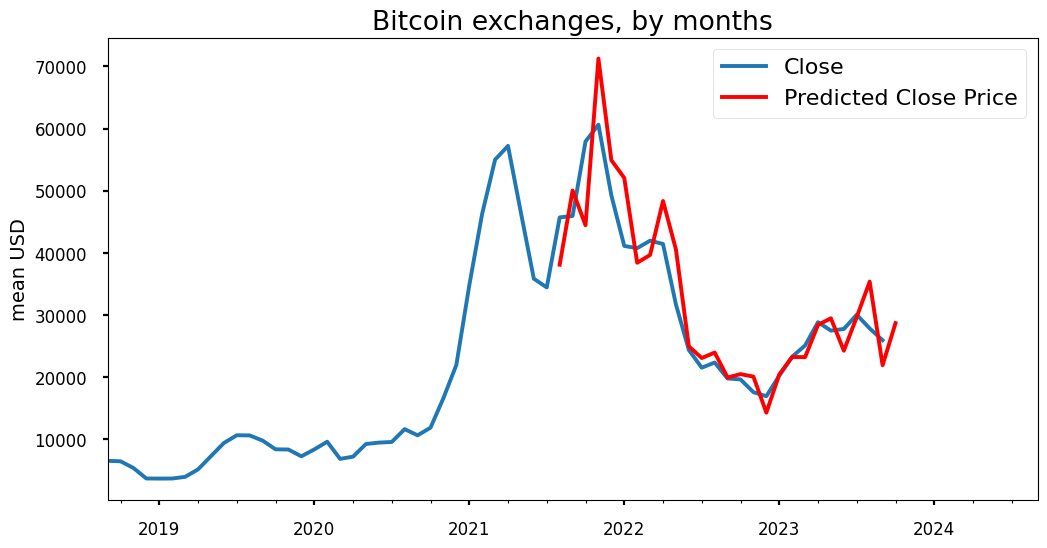

In [19]:
# Prediction
df_month2 = df_month[['Close']]
date_list = [datetime(2023,10, 1), datetime(2023, 11, 1), datetime(2023, 12, 1), datetime(2024, 1, 1),
             datetime(2024, 2, 1), datetime(2024, 3, 1),datetime(2024 ,4, 1), datetime(2024, 5, 1), datetime(2024,6, 1), datetime(2024, 7, 1),
             datetime(2024, 8, 1), datetime(2024, 9, 1) ]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=35, end=61), lmbda)
plt.figure(figsize=(12,6))
df_month2.Close.plot()
df_month2.forecast.plot(color='r', ls='-', label='Predicted Close Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [20]:
err = df_month['Close'][35:61] - df_month2['forecast'][35:61]

In [21]:
np.sqrt((err**2).mean())

5441.866458227262

In [22]:
import numpy as np

# Assuming you have arrays or lists for actual values and predicted values
actual_values = df_month['Close'][35:61]  # Replace [...] with your actual data
predicted_values = df_month2['forecast'][35:61]  # Replace [...] with your predicted data

# Calculate Mean Error (ME)
ME = np.mean(predicted_values - actual_values)

# Calculate Mean Squared Error (MSE)
MSE = np.mean((predicted_values - actual_values) ** 2)

# Calculate Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)

# Calculate Mean Absolute Error (MAE)
MAE = np.mean(np.abs(predicted_values - actual_values))

# Calculate Percentage Error (PE) for each data point
PE = ((predicted_values - actual_values) / actual_values) * 100

# Calculate Mean Percentage Error (MPE)
MPE = np.mean(PE)

# Calculate Mean Absolute Percentage Error (MAPE)
MAPE = np.mean(np.abs(PE))

# Print the results
print("Mean Squared Error (MSE):", MSE)
print("Root Mean Squared Error (RMSE):", RMSE)
print("Mean Absolute Error (MAE):", MAE)
print("Mean Absolute Percentage Error (MAPE):", MAPE)

Mean Squared Error (MSE): 29613910.549178924
Root Mean Squared Error (RMSE): 5441.866458227262
Mean Absolute Error (MAE): 3948.1145118319027
Mean Absolute Percentage Error (MAPE): 10.987368945292955


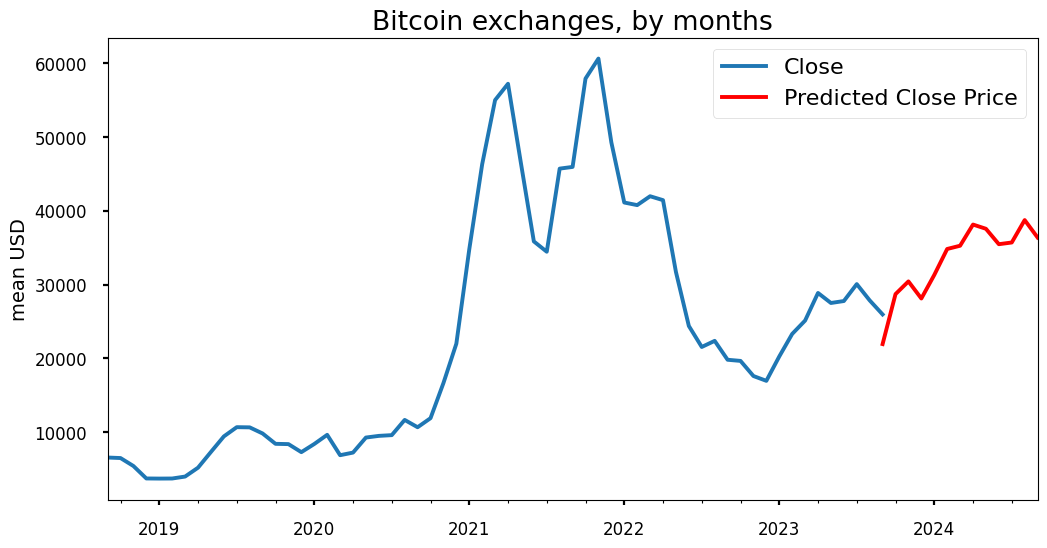

In [23]:
# Prediction
df_month2 = df_month[['Close']]
date_list = [datetime(2023,10, 1), datetime(2023, 11, 1), datetime(2023, 12, 1), datetime(2024, 1, 1),
             datetime(2024, 2, 1), datetime(2024, 3, 1),datetime(2024 ,4, 1), datetime(2024, 5, 1), datetime(2024,6, 1), datetime(2024, 7, 1),
             datetime(2024, 8, 1), datetime(2024, 9, 1) ]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=60, end=73), lmbda)
plt.figure(figsize=(12,6))
df_month2.Close.plot()
df_month2.forecast.plot(color='r', label='Predicted Close Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

**Using Prophet**

Prophet requires the variable names in the time series to be:

* y – Target
* ds – Datetime
So, the next step is to convert the dataframe according to the above specifications

In [24]:
df.reset_index(inplace=True)
df = df.rename(columns={'Date': 'ds',
                        'Close': 'y'})
df.head()

,ds,y,Month,Weekday
0,2018-09-15,6543.200195,9,5
1,2018-09-16,6517.180176,9,6
2,2018-09-17,6281.200195,9,0
3,2018-09-18,6371.299805,9,1
4,2018-09-19,6398.540039,9,2


In [25]:
df.reset_index(inplace=True)
df = df[['ds', 'y']].resample('MS', on='ds').mean()
df.reset_index(inplace=True)
df.head()

,ds,y
0,2018-09-01,6555.245666
1,2018-10-01,6485.118747
2,2018-11-01,5404.250171
3,2018-12-01,3717.488344
4,2019-01-01,3701.554963


**Fitting the Prophet model**

set the uncertainty interval to 95% (the Prophet default is 80%)

In [26]:
from prophet import Prophet
my_model = Prophet(interval_width=0.95)
my_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk85t0hyh/av2rsbvf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk85t0hyh/sg5vfvqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92983', 'data', 'file=/tmp/tmpk85t0hyh/av2rsbvf.json', 'init=/tmp/tmpk85t0hyh/sg5vfvqf.json', 'output', 'file=/tmp/tmpk85t0hyh/prophet_modelojh88d9g/prophet_model-20230920193944.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:39:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


To create a forecast with our model we need to create some future dates. Prophet provides us with a helper function called make_future_dataframe. We pass in the number of future periods and frequency. Above we created a forecast for the next 12 month or 1 year.

In [27]:
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')
future_dates

,ds
0,2018-09-01
1,2018-10-01
2,2018-11-01
3,2018-12-01
4,2019-01-01
...,...
68,2024-05-01
69,2024-06-01
70,2024-07-01
71,2024-08-01


**yhat** is our forcasted value

In [28]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-09-01,3826.403322,-21618.309297,30681.214709
1,2018-10-01,8618.171891,-16334.324349,34520.683647
2,2018-11-01,9319.987020,-17875.496285,36651.404434
3,2018-12-01,7629.961753,-17693.768362,31316.824177
4,2019-01-01,8643.333828,-16717.541930,33103.426339
...,...,...,...,...
68,2024-05-01,44007.778000,17674.923537,66858.686255
69,2024-06-01,40155.038620,15317.036909,65955.992724
70,2024-07-01,39263.425662,15037.445652,64064.578827
71,2024-08-01,45185.212609,19606.089165,68737.669552


**Let's Calculate the MSE and RMSE for the Prophet Model**

In [29]:
mse = ((df['y'] - forecast['yhat']) ** 2).mean()
print('The Mean Squared Error (MSE) of our forecasts is {}'.format(round((mse),2)))
print('The Root Mean Squared Error (RMSE) of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error (MSE) of our forecasts is 168313893.32
The Root Mean Squared Error (RMSE) of our forecasts is 12973.58


**Let's create a graph of our actuals and forecast**

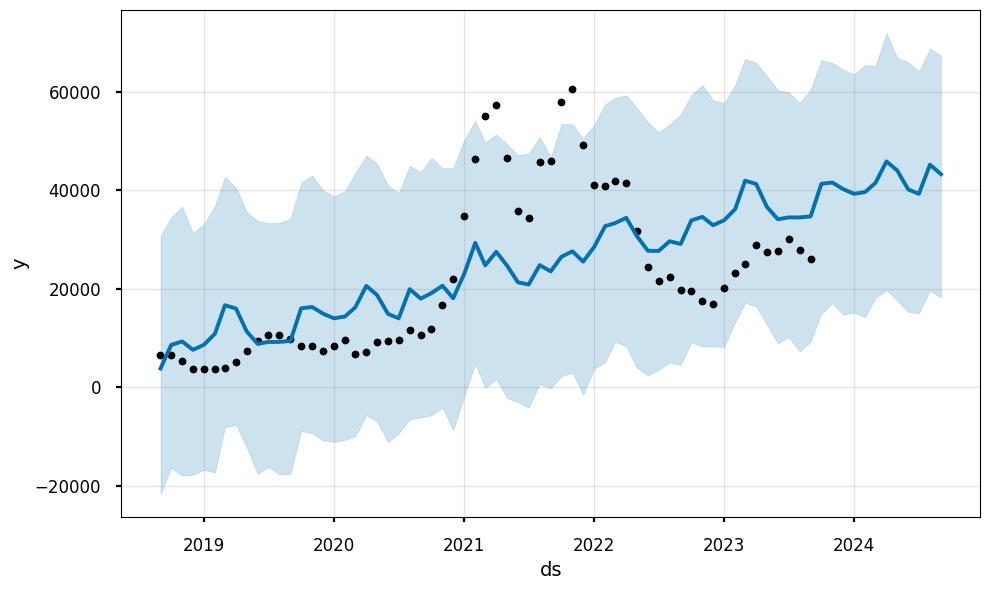

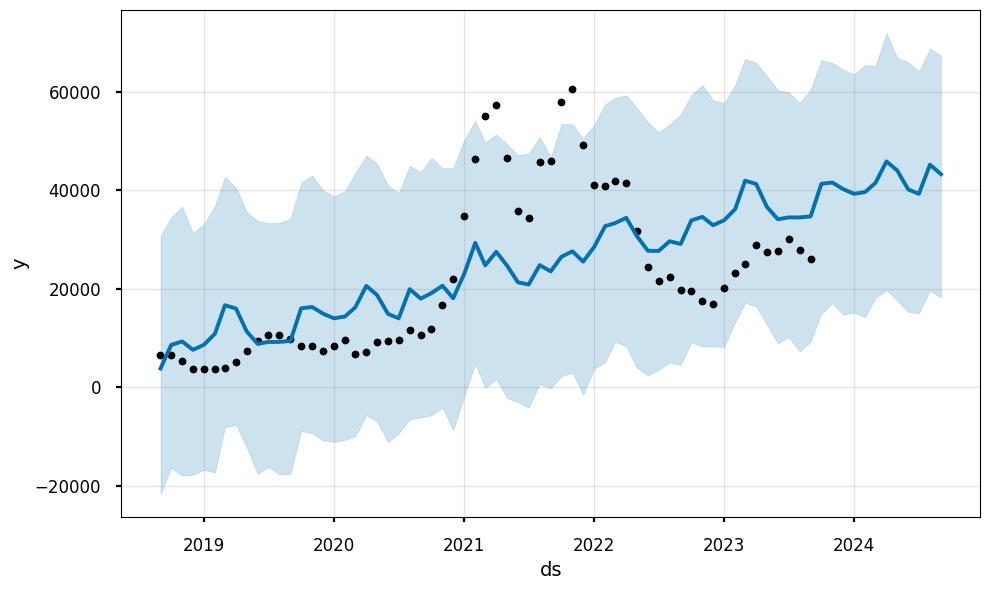

In [30]:
pd.plotting.register_matplotlib_converters()
my_model.plot(forecast, uncertainty=True)

plot_components provides us a graph of our trend and seasonality

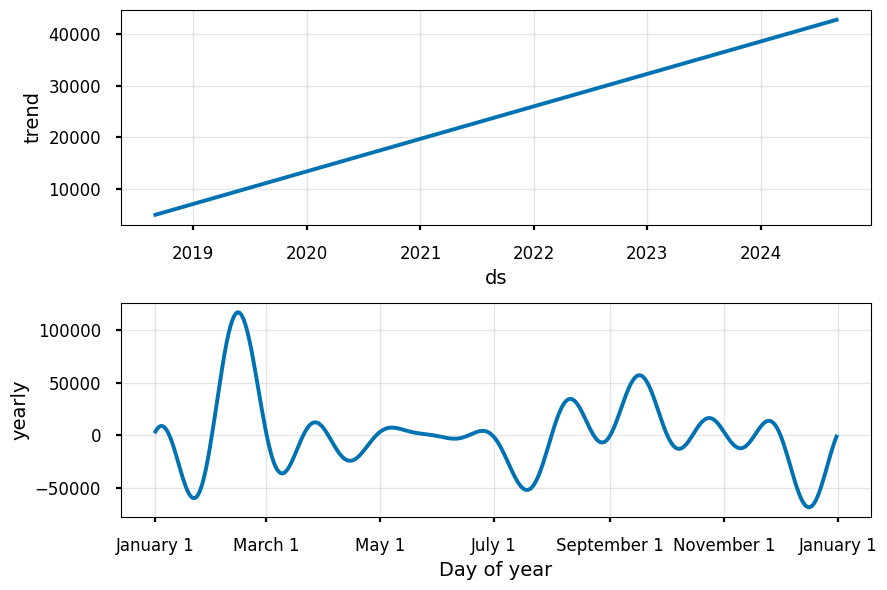

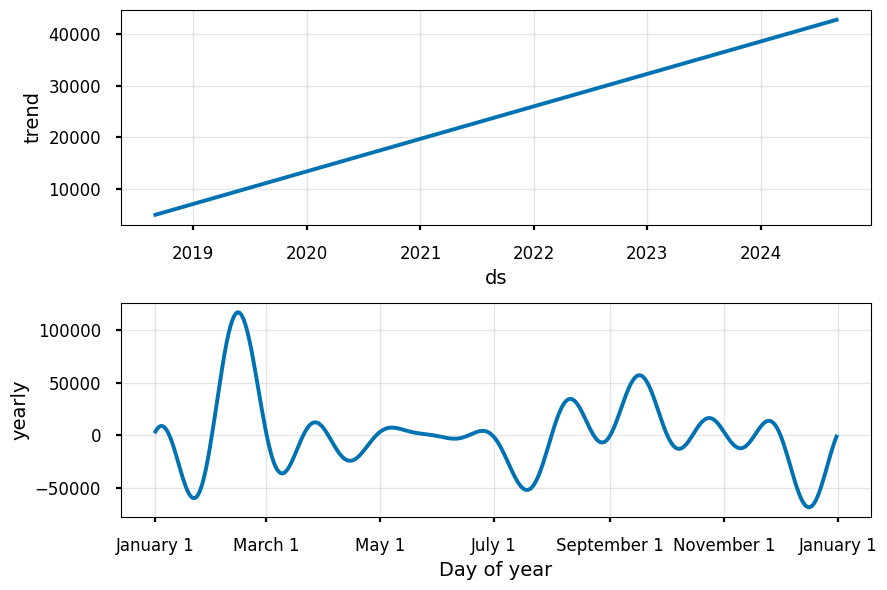

In [31]:
my_model.plot_components(forecast)

Let's Cross Validate our model's performance

In [32]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, initial='1278 days', period='549 days', horizon = '365 days')
df_cv

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p['rmse'].mean()

INFO:prophet:Making 1 forecasts with cutoffs between 2022-09-01 00:00:00 and 2022-09-01 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk85t0hyh/8s54ndhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk85t0hyh/bhelpivx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31996', 'data', 'file=/tmp/tmpk85t0hyh/8s54ndhy.json', 'init=/tmp/tmpk85t0hyh/bhelpivx.json', 'output', 'file=/tmp/tmpk85t0hyh/prophet_modelitig9210/prophet_model-20230920193946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


27992.176506339467

> In Conclusion RMSE of ARIMA < RMSE of Prophet, So that, ARIMA performed better for our dataset. We can make further analysis to improve the models.